In [57]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from scipy.ndimage.interpolation import shift

In [310]:
# Susceptible, Exposed, Infectious, Recovered/isolated and going to recover, Isolated and going to die, Died

def seir(y, t, beta, epsilon, mu, f,fr, n):
    s, e, i, r, preD1, preD2, preD3, d = y
    dydt = [-beta*i*s/n, 
            beta*i*s/n - epsilon * e, 
            epsilon*e - mu*i, 
            (1-f)*mu*i, 
            mu*f*i-3*fr*preD1,
            3*fr*preD1-3*fr*preD2,
            3*fr*preD2-3*fr*preD3,
            3*fr*preD3 ]
    return dydt

# Run until measures change, run again with new parameters

def sim(beta,epsilon,mu,f,y0,betap,fr = 1/17,tswitch=17,tend=250):
    n = y0.sum()
    t = np.linspace(1,tswitch,tswitch)
    t1 = np.linspace(tswitch+1,tend,tend-tswitch)
    sol0 = odeint(seir,y0,t,args=(beta,epsilon,mu,f,fr,n))
    sol1 = odeint(seir,sol0[-1],t1,args=(betap,epsilon,mu,f,fr,n))
    return np.append(sol0,sol1[1:],axis=0)

# See footnote 7 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2760158/

def beta(red, beta0 = 1.285,mu=0.5,epsilon=0.2,kappa0=np.log(1.21)):
    kappa = np.maximum(kappa0 + np.log(1-red),np.log(1-epsilon)) 
    nu = 1/epsilon + 1/mu
    te = 1/epsilon
    f = te/nu
    # This should ensure beta is >0, but for some reason I only get beta > -0.03
    return np.minimum(np.maximum(mu*(1+kappa*nu + f*(1-f)*kappa**2*nu**2),0),beta0*(1-red))

def r0_mult(red,beta0=1.285,kappa0=np.log(1.21),mu=0.5,epsilon=0.2):
    return beta(red,beta0=beta0,kappa0=kappa0,epsilon=epsilon,mu=mu)/beta0

In [311]:
beta(0,kappa0=np.log(1.18),beta0=1.6,mu=0.25)

0.759382633297272

In [322]:
.76/.2

3.8

In [313]:
beta(0,kappa0=np.log(1.06))

0.720917506703717

In [314]:
# Events, hygiene + masks, healthcare spec, close school, 
# close businesses some, close businesses many, gatherings < 10, blanket curfew

# Best guess, low, high
# 68% not 95% intervals as I'm multiplying them together
# Reduced schools effectiveness to be in line with business closures, but boosted its upper end

CMS = np.array([[0.033,0.018,0.048],
                [0.016,0,0.036],
                [0.057,0.037,0.077],
                [0.06,0.04,0.1],
                [0.018,0.003,0.033],
                [0.019,0.004,0.034],
                [0.038,0.02,0.055],
                [0.044,0.025,0.064]])

cms_li = (1-CMS[:2]).prod(0)
cms_mi = (1-CMS[:5]).prod(0)
cms_hi = (1-CMS).prod(0)

REDS = np.array([1-cms_li,1-cms_mi,1-cms_hi])

REDS,'R0',1-r0_mult(1-cms_li),1-r0_mult(1-cms_mi),1-r0_mult(1-cms_hi)

(array([[0.048472  , 0.018     , 0.082272  ],
        [0.17172871, 0.09488416, 0.26280112],
        [0.25273511, 0.13862117, 0.37010313]]),
 'R0',
 array([0.1497417 , 0.02544483, 0.28283177]),
 array([0.60486793, 0.33106024, 0.87134151]),
 array([0.84574741, 0.49146477, 1.        ]))

In [315]:
1-r0_mult(CMS)

array([[0.08710712, 0.02544483, 0.14784608],
       [0.01715648, 0.        , 0.09933063],
       [0.18382164, 0.10339685, 0.26243185],
       [0.19573256, 0.11557041, 0.3503847 ],
       [0.02544483, 0.003     , 0.08710712],
       [0.02958324, 0.004     , 0.09118575],
       [0.1074589 , 0.03371777, 0.17585833],
       [0.1317426 , 0.05433183, 0.21154942]])

In [323]:
BETA = .76
EPSILON = 0.2

# Wild guess at time to progress from "isolated + going to die" to "dead"

FR = 1/16

# Fatalaties

Fm, Fl, Fu = 0.008,0.003,0.015

F = np.array([Fm,Fl,Fu])

# Best guess infectivity R0 = 3

# Low infectivity R0 = 2.3 (short infectious window might be unrealistic)

# High infectivity R0 = 3.8

MU= np.array([0.25,0.325,0.2])

kappa0s = np.log(np.array([1.21,1.3,1.14]))

# 1) Best guess initial conditions, April 13 
# 2) low detection, low mortality, high infectivity 
# 3) high detection high mortality, low infectivity
# Susceptible, Exposed, Infectious, Recovered/isolated and going to recover, Isolated and going to die, Died

y0 = np.array([[210e6 - 606e3-70e3-214e3,214e3, 70e3, 606e3*(1-Fm),606e3*Fm*2/7,606e3*Fm*2/7,606e3*Fm*1/7, 1328  ],
               [210e6 - 1.7e6-613e3-202e3,613e3, 202e3, 1.7e6*(1-Fl),1.e6*Fl*2/7,1.e6*Fl*2/7,1.e6*Fl*1/7, 1328],
               [210e6 - 347e3-40e3-122e3,122e3, 40e3, 347e3*(1-Fu),447e3*Fu*2/7,447e3*Fu*2/7,447e3*Fu*1/7, 1328]])



In [324]:
REDS[0:1,0].mean()

0.04847200000000007

In [325]:
output = []

for reds in REDS:
    traces = dict()
    # MU, kappa0, F, y0, red
    params = np.array([[mu, kappa, f, y,red,REDS[0:2,j].mean()] for mu, kappa in zip(MU,kappa0s) for f, y in zip(F,y0) for j, red in enumerate(reds)])
    for i, (mu, kappa0, f, y0s, red, red0) in enumerate(params):
        bp = beta(red,mu=mu,kappa0=kappa0)
        b0 = beta(red0,mu=mu,kappa0=kappa0)
        s,e,inf,r,pD1,pD2,pD3,d = sim(b0,EPSILON,mu,f,y0s,bp).T
        traces['S'+str(i)] = s
        traces['E'+str(i)] = e
        traces['I'+str(i)] = inf
        traces['R'+str(i)] = r
        traces['D'+str(i)] = d
    output.append(traces)

In [326]:
df_li = pd.DataFrame(output[0],index=pd.date_range(start='04/13/2020',periods=249))
a = df_li.iloc[[18,49,232],df_li.columns.str.startswith('D')]
a['D0'], a.max(1), a.min(1)

(2020-05-01    5.261992e+03
 2020-06-01    7.543293e+04
 2020-12-01    1.530926e+06
 Name: D0, dtype: float64,
 2020-05-01    8.277467e+03
 2020-06-01    1.035444e+06
 2020-12-01    3.079431e+06
 dtype: float64,
 2020-05-01      3772.807683
 2020-06-01      8848.061843
 2020-12-01    351200.281815
 dtype: float64)

In [327]:
df_mi = pd.DataFrame(output[1],index=pd.date_range(start='04/13/2020',periods=249))
a = df_mi.iloc[[18,49,232],df_li.columns.str.startswith('D')]
a['D0'], a.max(1), a.min(1)

(2020-05-01      5261.971173
 2020-06-01     23410.435368
 2020-12-01    137519.080315
 Name: D0, dtype: float64,
 2020-05-01    8.277312e+03
 2020-06-01    5.921567e+05
 2020-12-01    2.892423e+06
 dtype: float64,
 2020-05-01    3772.804999
 2020-06-01    6984.625121
 2020-12-01    7290.818895
 dtype: float64)

In [328]:
df_hi = pd.DataFrame(output[2],index=pd.date_range(start='04/13/2020',periods=249))
a = df_hi.iloc[[18,49,232],df_li.columns.str.startswith('D')]
a['D0'], a.max(1), a.min(1)

(2020-05-01     5261.962144
 2020-06-01    17654.909069
 2020-12-01    20847.095470
 Name: D0, dtype: float64,
 2020-05-01    8.277232e+03
 2020-06-01    3.732008e+05
 2020-12-01    2.605756e+06
 dtype: float64,
 2020-05-01    3772.804992
 2020-06-01    6982.589900
 2020-12-01    7286.852710
 dtype: float64)

In [332]:
# Testing requirements, best guess only

a = df_li.iloc[[18,49,232],df_li.columns.str.startswith('I0')|df_li.columns.str.startswith('E0')]
a.sum(1)*20*7/9

2020-05-01    1.824986e+07
2020-06-01    6.791084e+08
2020-12-01    6.652490e+00
dtype: float64

In [333]:
a = df_mi.iloc[[18,49,232],df_mi.columns.str.startswith('I0')|df_mi.columns.str.startswith('E0')]
a.sum(1)*20*7/9

2020-05-01    1.359890e+07
2020-06-01    1.363676e+07
2020-12-01    5.691517e+06
dtype: float64

In [334]:
a = df_hi.iloc[[18,49,232],df_hi.columns.str.startswith('I0')|df_hi.columns.str.startswith('E0')]
a.sum(1)*20*7/9

2020-05-01    1.167431e+07
2020-06-01    5.428983e+05
2020-12-01    4.690069e-03
dtype: float64

In [47]:
df_hi = pd.DataFrame(output[2],index=pd.date_range(start='04/12/2020',periods=249))

In [48]:
df_hi.iloc[[18,51,233],df_hi.columns.str.startswith('D')]

,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26
2020-04-30,7673.589956,7676.491779,7672.345285,7564.474121,7567.205404,7563.301577,7655.564639,7.658493e+03,7654.308799,9150.318682,...,9130.438797,6052.567450,6053.170258,6052.486722,5984.110774,5984.694111,5984.032637,6037.063212,6037.666968,6036.982362
2020-06-02,23253.021246,51781.826180,20141.462344,22539.535247,46830.382575,19649.602407,23286.261952,5.300204e+04,20133.634381,45425.673857,...,28118.071921,12330.531334,15936.826860,12102.344984,12152.576325,15576.009041,11932.462833,12298.160728,15930.379257,12069.406378
2020-12-01,27347.604656,721378.801763,22365.159990,26397.464531,276960.442357,21800.564321,27418.788893,1.333193e+06,22360.448714,78811.358566,...,31514.120764,13503.811268,29598.659127,13163.962134,13302.789548,27311.186274,12975.171518,13469.027227,30140.759224,13128.269778


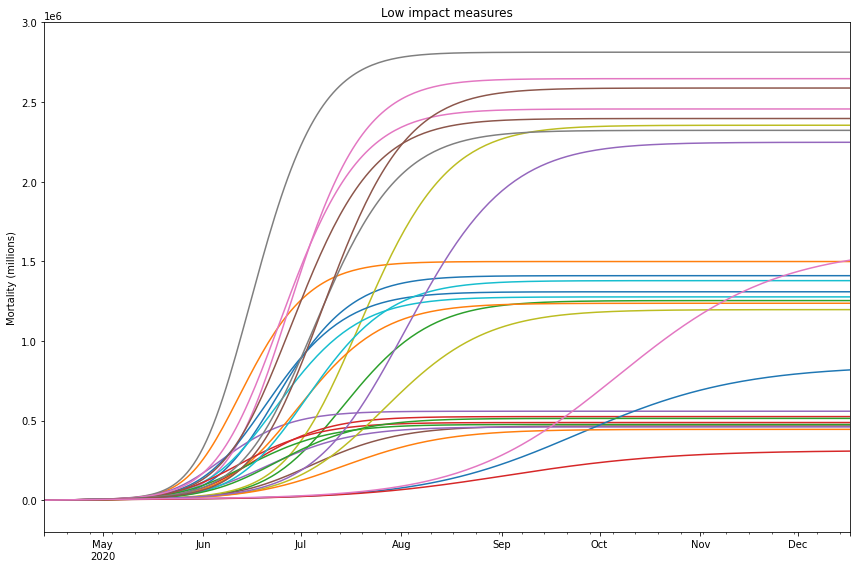

In [266]:
fig,ax = plt.subplots(figsize=(12,8))
# df_li = df_li.rename(columns={'D0':'Best guess','D1':'Low range', 'D2':'High range'})

df_li.loc[:,df_li.columns.str.startswith('D')].plot(ax=ax,legend=False)
ax.set_ylabel('Mortality (millions)')
ax.set_title('Low impact measures')
ax.set_ylim([-.2e6,3.e6])
plt.tight_layout()
plt.savefig('low_impact_measures.png')

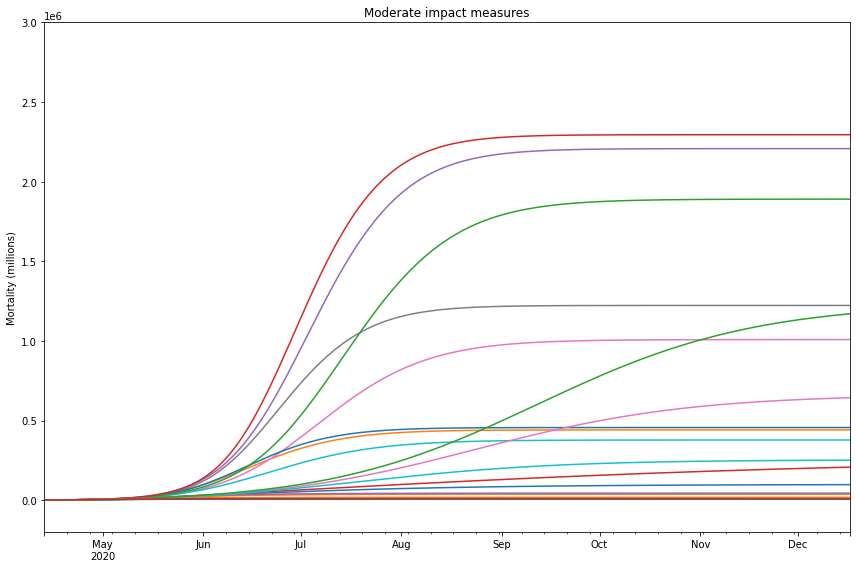

In [267]:
fig,ax = plt.subplots(figsize=(12,8))
df_mi = df_mi.rename(columns={'D0':'Best guess','D1':'Low range', 'D2':'High range'})

df_mi.loc[:,df_mi.columns.str.startswith('D')].plot(ax=ax,legend=False)
ax.set_ylabel('Mortality (millions)')
ax.set_title('Moderate impact measures')
ax.set_ylim([-.2e6,3.e6])
plt.tight_layout()
plt.savefig('med_impact_measures.png')

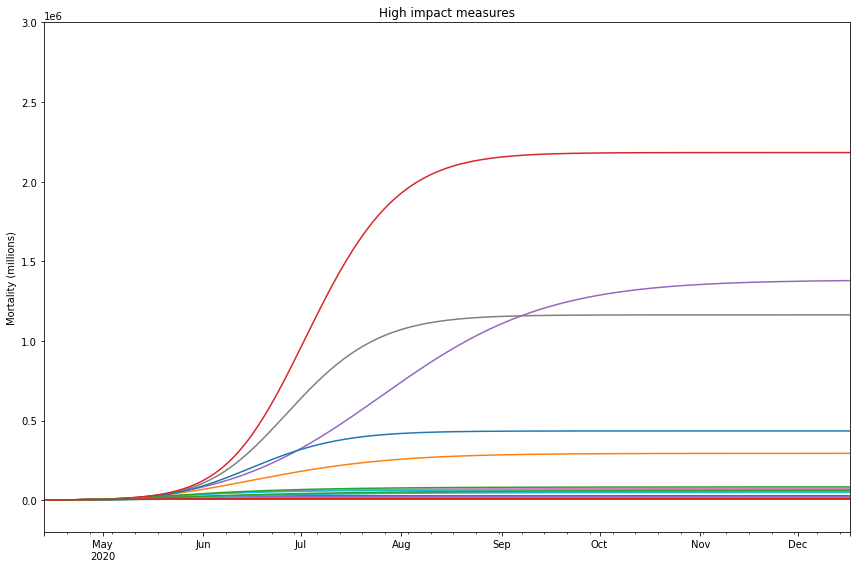

In [268]:
fig,ax = plt.subplots(figsize=(12,8))
df_hi = df_hi.rename(columns={'D0':'Best guess','D1':'Low range', 'D2':'High range'})

df_hi.loc[:,df_hi.columns.str.startswith('D')].plot(ax=ax,legend=False)
ax.set_ylabel('Mortality (millions)')
ax.set_title('High impact measures')
ax.set_ylim([-.2e6,3.e6])
plt.tight_layout()
plt.savefig('high_impact_measures.png')

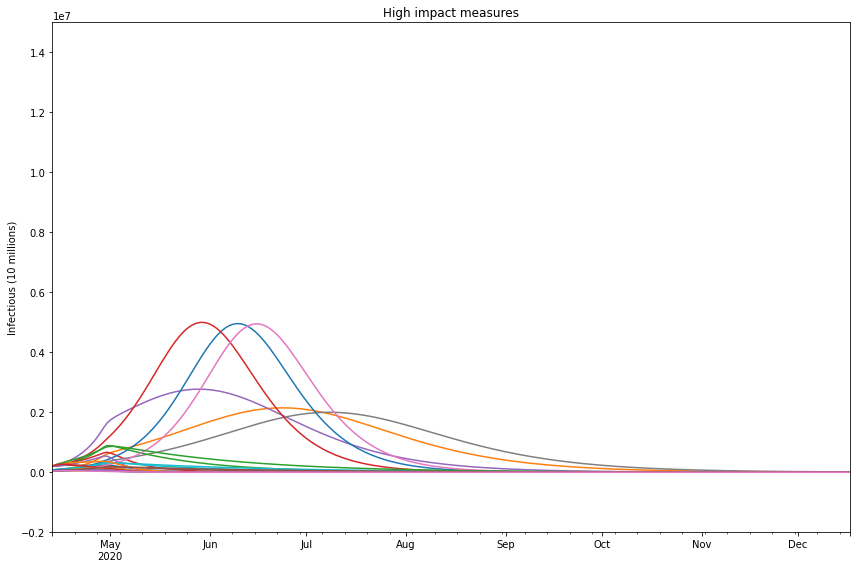

In [269]:
fig,ax = plt.subplots(figsize=(12,8))

df_hi.loc[:,df_hi.columns.str.startswith('I')].plot(ax=ax,legend=False)
ax.set_ylabel('Infectious (10 millions)')
ax.set_title('High impact measures')
ax.set_ylim([-0.2e7,1.5e7])
plt.tight_layout()

plt.savefig('high_impact_measures_inf.png')

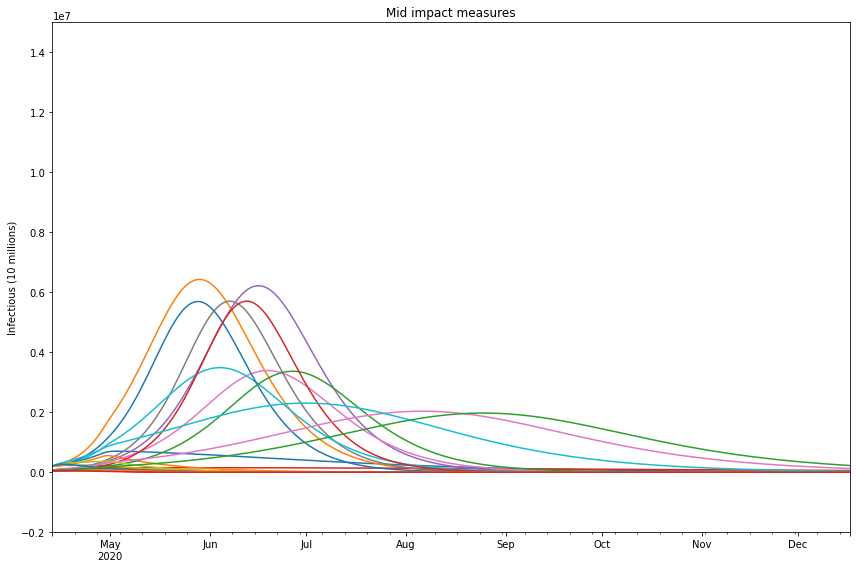

In [271]:
fig,ax = plt.subplots(figsize=(12,8))
df_mi = df_mi.rename(columns={'I0':'Best guess infectious','I1':'Low range infectious', 'I2':'High range infectious'})

df_mi.loc[:,df_mi.columns.str.startswith('I')].plot(ax=ax,legend=False)
ax.set_ylabel('Infectious (10 millions)')
ax.set_title('Mid impact measures')
ax.set_ylim([-0.2e7,1.5e7])
plt.tight_layout()
plt.savefig('mid_impact_measures_inf.png')

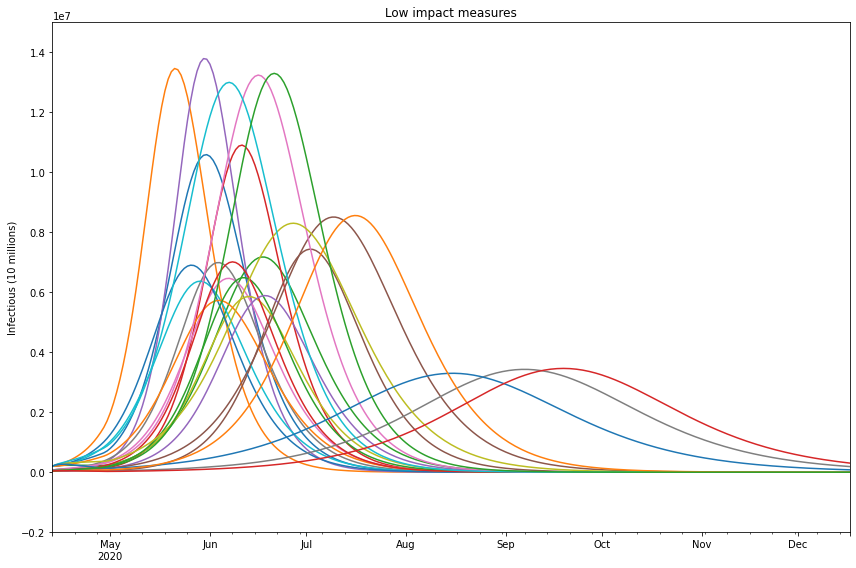

In [272]:
fig,ax = plt.subplots(figsize=(12,8))
df_li = df_li.rename(columns={'I0':'Best guess infectious','I1':'Low range infectious', 'I2':'High range infectious'})

df_li.loc[:,df_li.columns.str.startswith('I')].plot(ax=ax,legend=False)
ax.set_ylabel('Infectious (10 millions)')
ax.set_title('Low impact measures')
ax.set_ylim([-0.2e7,1.5e7])
plt.tight_layout()
plt.savefig('low_impact_measures_inf.png')